In [1]:
from prophet import Prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
from tqdm import tqdm
from time import time 

c:\Users\luish\Anaconda3\envs\spyder\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ventas_raw = pd.read_csv("ventas_normalizadas.csv")
ventas_categoria = ventas_raw.groupby(["fecha", "categoria_sk"]).sum().sort_values("valor_vendido", ascending=False)
ventas_categoria = ventas_categoria.reset_index()
ventas_categoria["ds"] = pd.to_datetime(ventas_categoria["fecha"])
ventas_categoria.drop(columns=["producto_sk", "fecha"], inplace=True)
groups_by_cat = ventas_categoria.groupby('categoria_sk')
groups_by_cat.groups.keys()

C:\Users\luish\AppData\Local\Temp\ipykernel_19792\3889571718.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ventas_categoria = ventas_raw.groupby(["fecha", "categoria_sk"]).sum().sort_values("valor_vendido", ascending=False)


dict_keys([146, 151, 156, 162, 164, 169, 170, 176, 177, 182, 183, 184, 188, 192, 193, 194, 200, 203, 205, 207, 208, 209, 212, 214, 215, 216, 218, 219, 222, 223, 224, 229, 233, 234, 235, 236, 239, 241, 242, 245, 249, 252, 253, 254, 256, 258, 259, 263, 266, 267, 268, 270, 272, 275, 276, 278, 279, 283, 285, 288])

In [3]:
ventas_categoria["valor_vendido_imputado"] = np.nan
medianas = ventas_categoria.groupby("categoria_sk").median()

l = []
for row in ventas_categoria.iterrows():
    
    if row[1][2] < 100:
        l.append(medianas.loc[row[1][0]]["valor_vendido"])
    else:
        l.append(row[1][2]) 
        
        
    
ventas_categoria["valor_vendido_imputado"] = l

C:\Users\luish\AppData\Local\Temp\ipykernel_19792\2847587805.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medianas = ventas_categoria.groupby("categoria_sk").median()


20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:22 - cmdstanpy - INFO - Chain [1] done processing
20:47:22 - cmdstanpy - INFO - Chain [1] start processing
20:47:52 - cmdstanpy - INFO - Chain [1] done processing
20:47:52 - cmdstanpy - INFO - Chain [1] start processing
20:47:53 - cmdstanpy - INFO - Chain [1] done processing
20:47:53 - cmdstanpy - INFO - Chain [1] start processing
20:47:54 - cmdstanpy - INFO - Chain [1] done processing
20:47:55 - cmdstanpy - INFO - Chain [1] start processing
20:47:56 - cmdstanpy - INFO - Chain [1] done processing
20:47:56 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:58 - cmdstanpy - INFO - Chain [1] done processing
20:47:59 - cmdstanpy - INFO - Chain [1] start processing
20:48:27 - cmdstanpy - INFO - Chain [1] done processing
20:48:27 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1]

The time used for the for-loop forecast is  331.77436804771423


<AxesSubplot: >

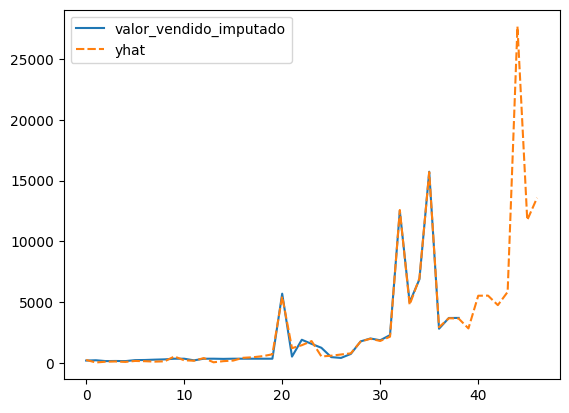

In [5]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}

def train_and_forecast4(group, tail=3, pred=8):

    # Initiate the model
    m = Prophet(changepoint_prior_scale=0.5,
                seasonality_prior_scale= 1,
                seasonality_mode='multiplicative')

    group.sort_values("ds").head(group.shape[0]-tail)
    
    # Fit the model
    m.fit(group)

    # Make predictions
    future = m.make_future_dataframe(periods=pred, freq="MS")
    forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast['categoria_sk'] = group['categoria_sk'].iloc[0]

    # Return the forecasted results
    return forecast[['ds', 'categoria_sk', 'yhat', 'yhat_upper', 'yhat_lower']]  

# Start time
start_time = time()

# Create an empty dataframe
valor_forecast = pd.DataFrame()

# Loop through each ticker
for categoria in groups_by_cat.groups.keys():
    # Get the data for the ticker
    group = groups_by_cat.get_group(categoria)    
    # Make forecast
    forecast = train_and_forecast4(group.rename(columns={"valor_vendido_imputado":"y"}))    
    # Add the forecast results to the dataframe
    valor_forecast = pd.concat((valor_forecast, forecast))
    
print('The time used for the for-loop forecast is ', time()-start_time)

tablaf = valor_forecast.merge(ventas_categoria, on=['ds', 'categoria_sk'], how='left')
tablaf = tablaf[['ds', 'categoria_sk', 'valor_vendido_imputado','yhat']]
df146 = tablaf[tablaf["categoria_sk"]== 146]
df146 = df146[['ds', 'valor_vendido_imputado','yhat']]
sns.lineplot(data=df146)

In [7]:
tablaf

,ds,categoria_sk,valor_vendido_imputado,yhat
0,2019-01-01,146,214.90,265.170160
1,2019-02-01,146,238.84,56.802787
2,2019-03-01,146,170.46,120.859573
3,2019-04-01,146,179.99,139.944708
4,2019-05-01,146,169.24,103.533378
...,...,...,...,...
2823,2022-08-01,288,NaN,8184.374470
2824,2022-09-01,288,NaN,7512.970054
2825,2022-10-01,288,NaN,6797.243382
2826,2022-11-01,288,NaN,6914.423330


In [9]:
cat = tablaf['categoria_sk'].unique()

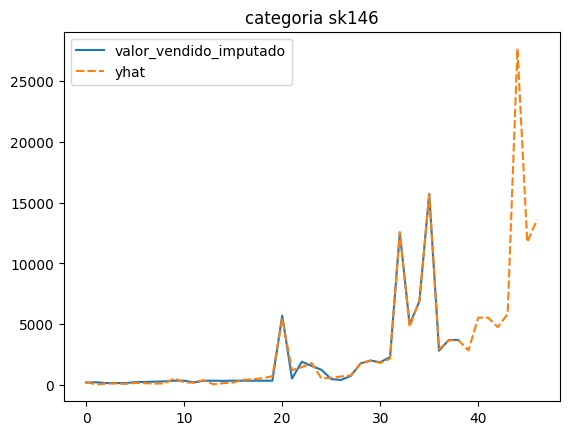

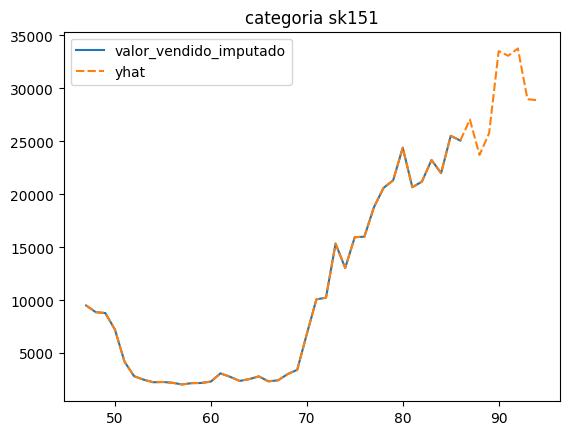

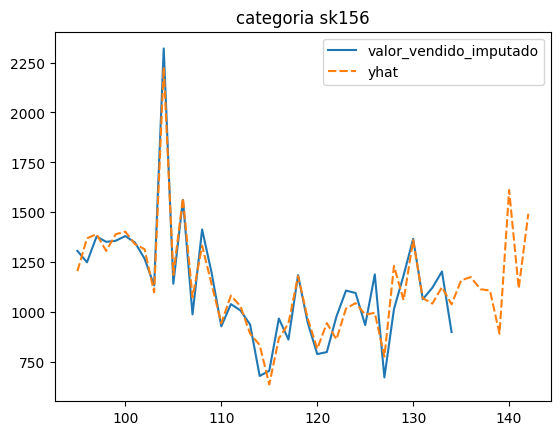

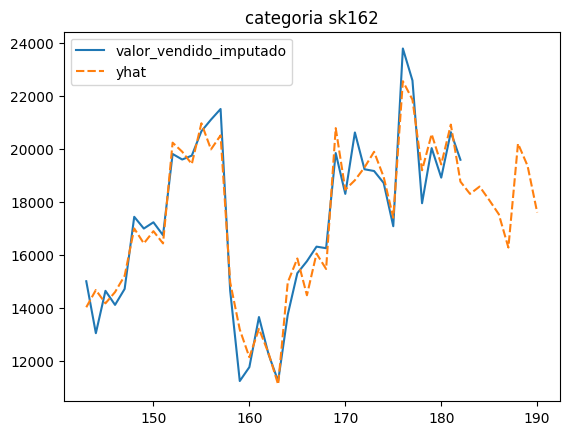

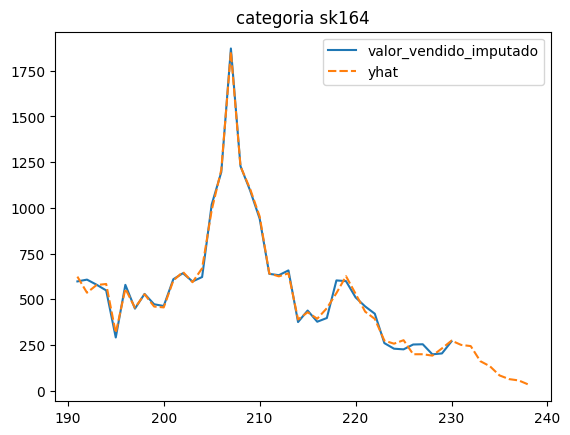

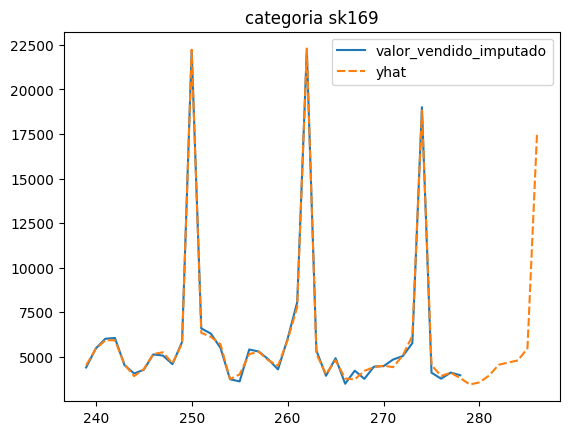

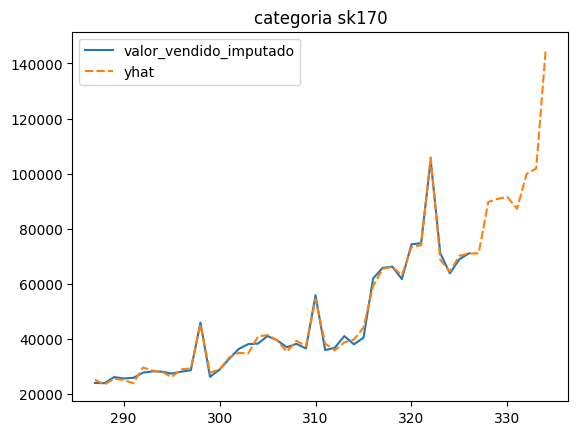

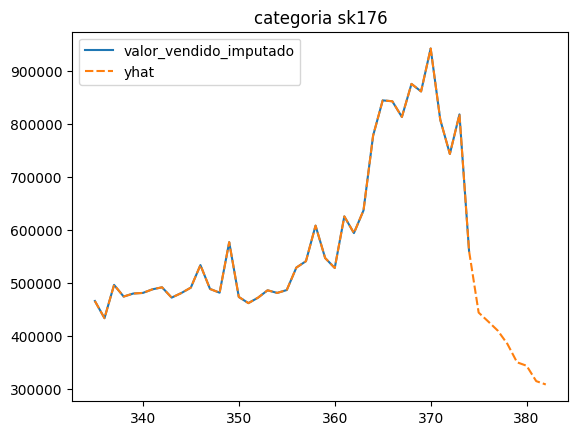

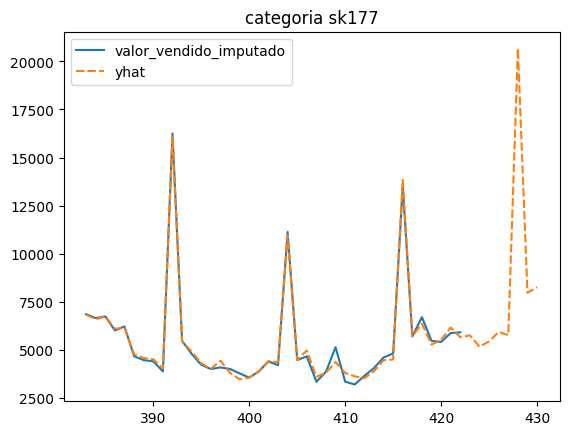

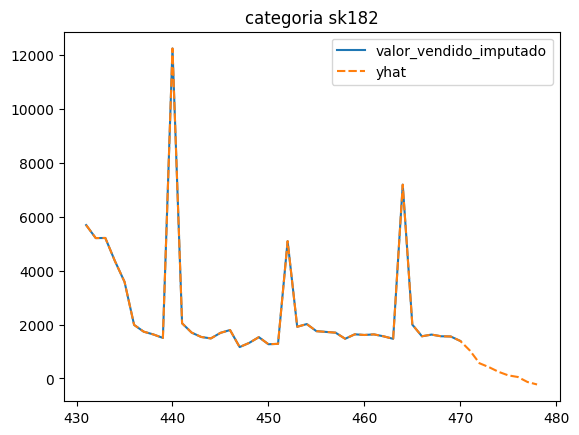

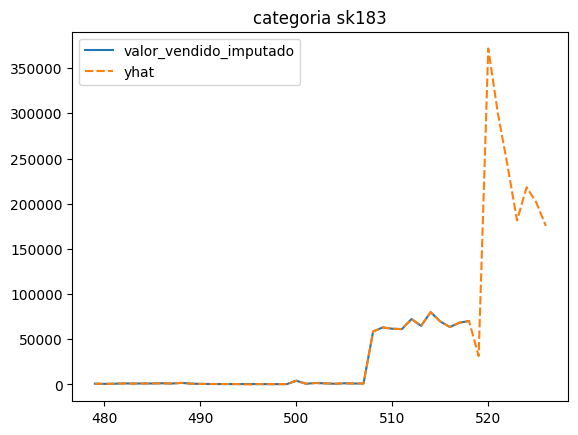

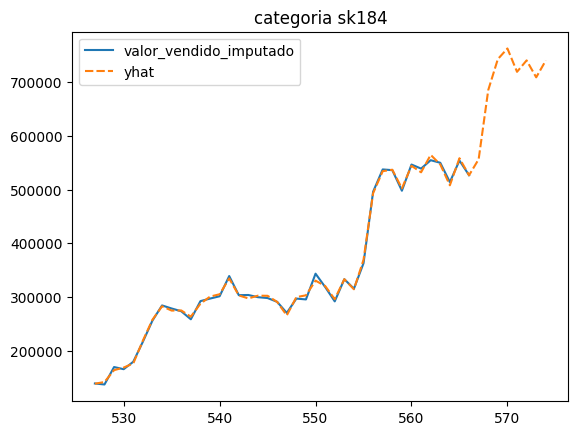

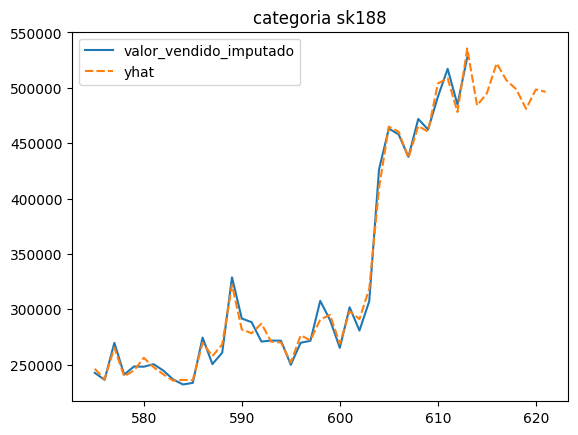

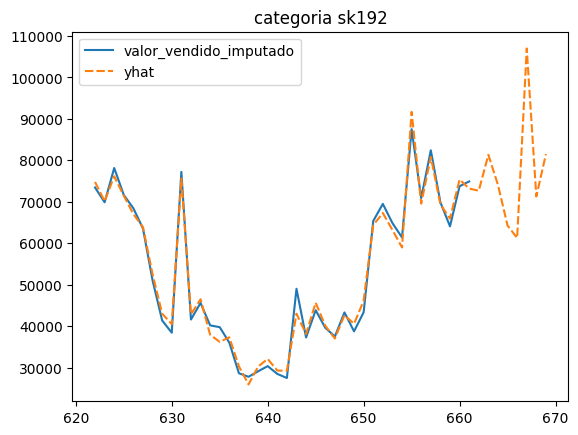

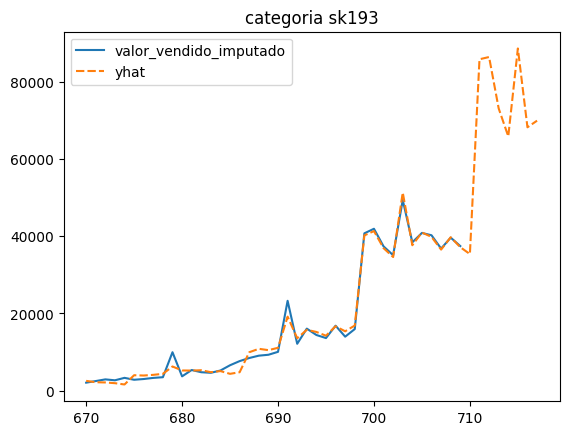

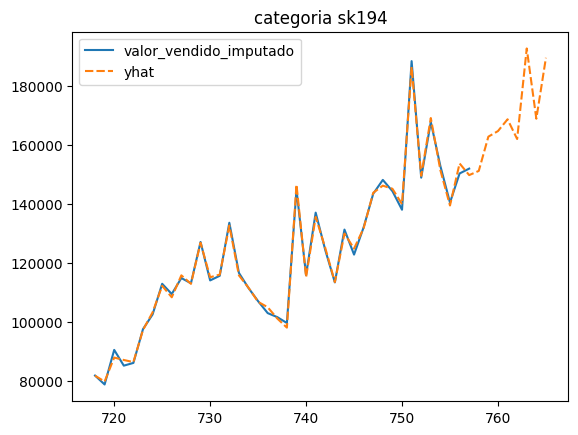

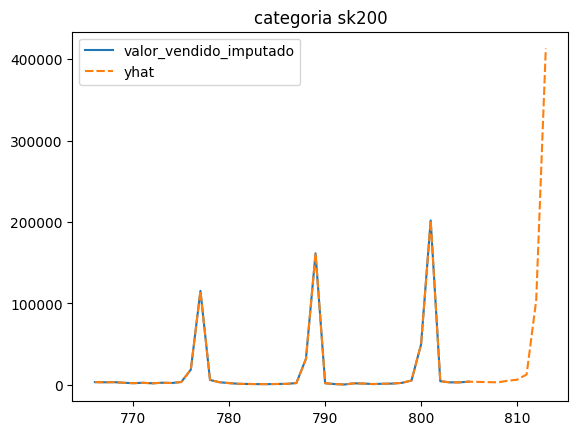

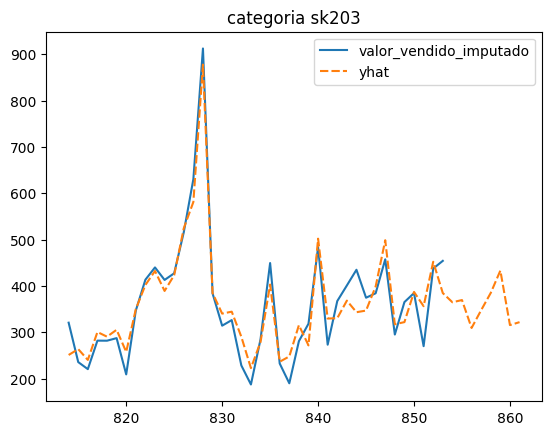

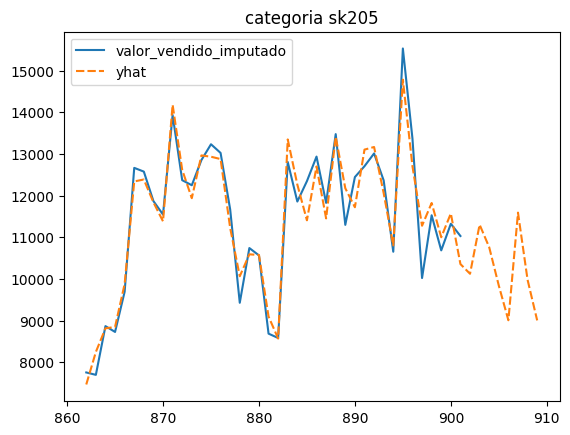

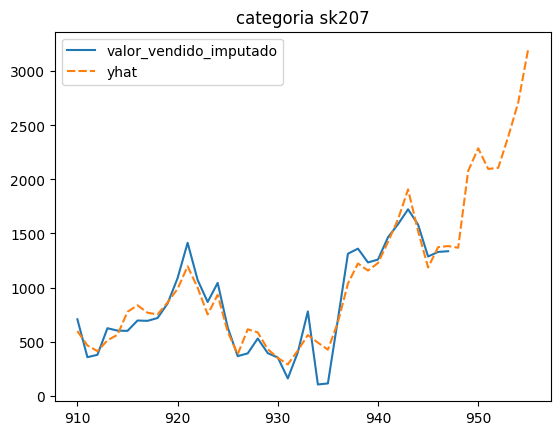

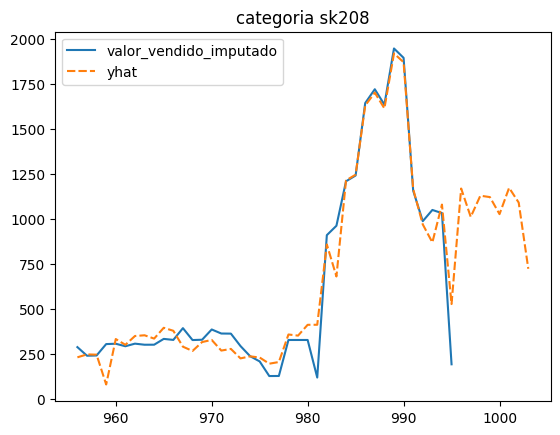

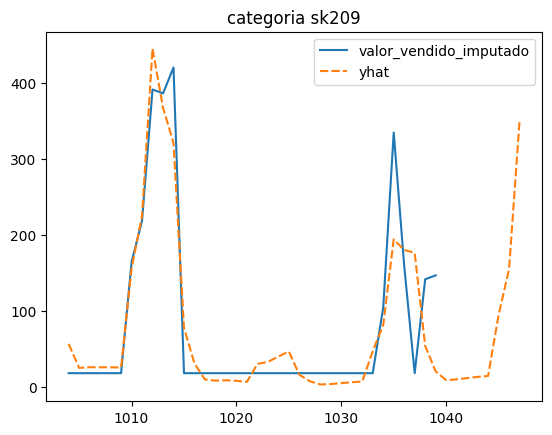

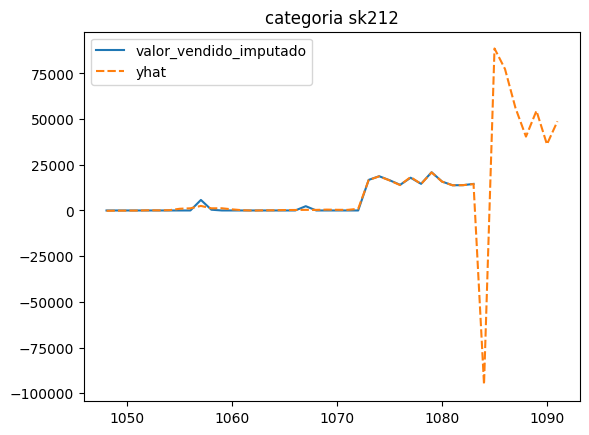

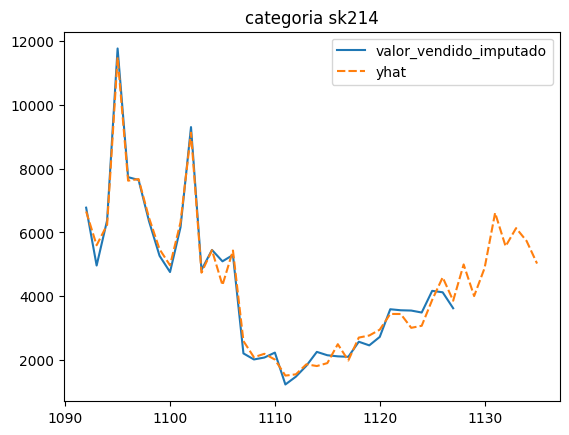

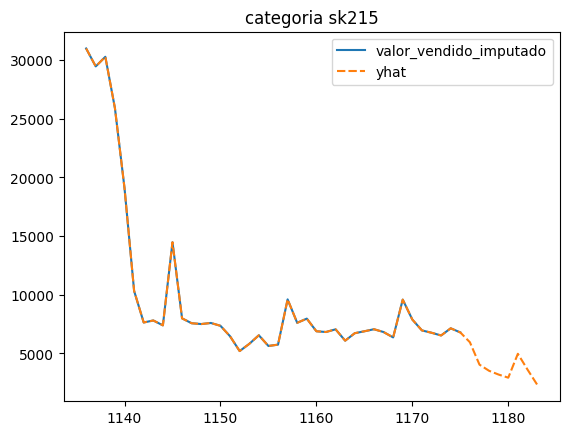

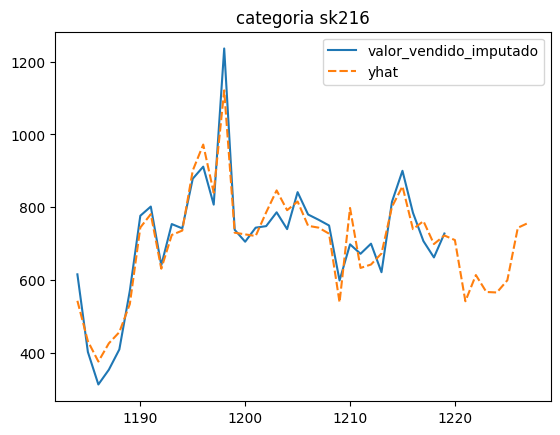

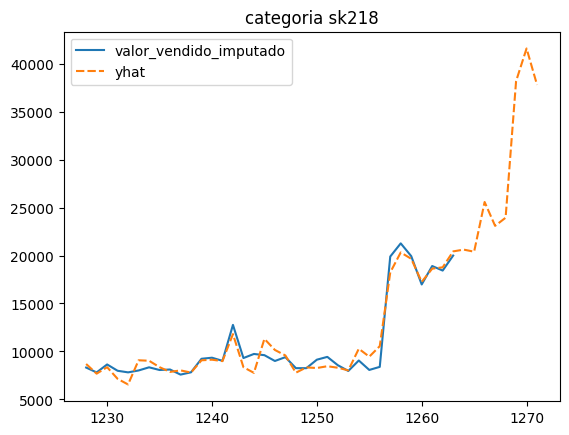

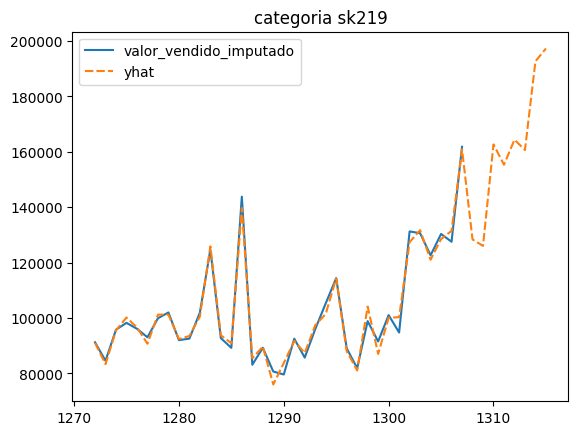

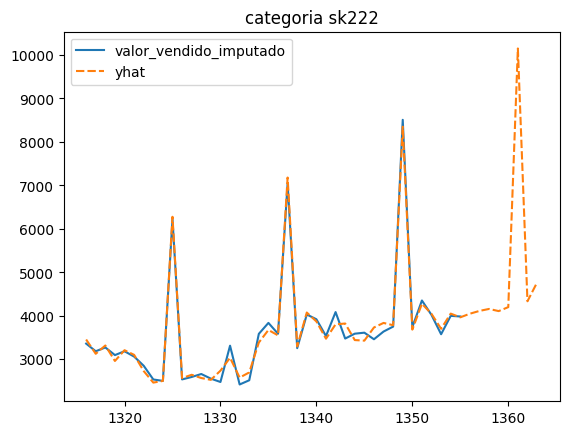

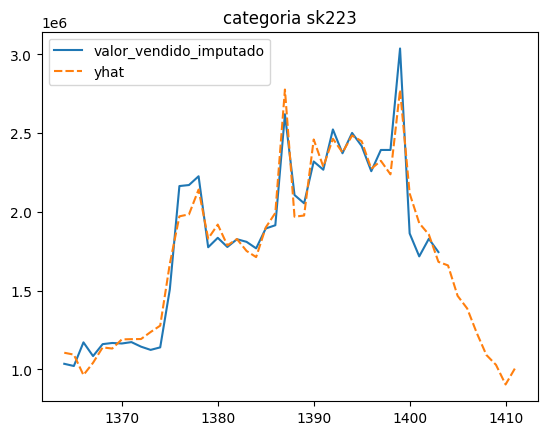

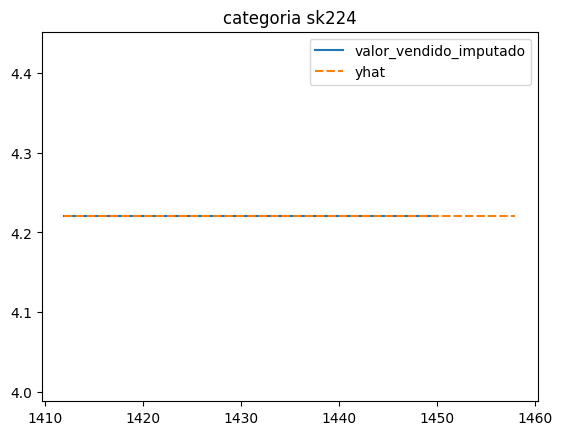

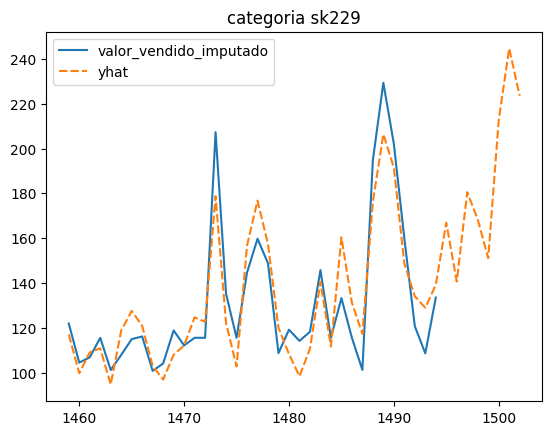

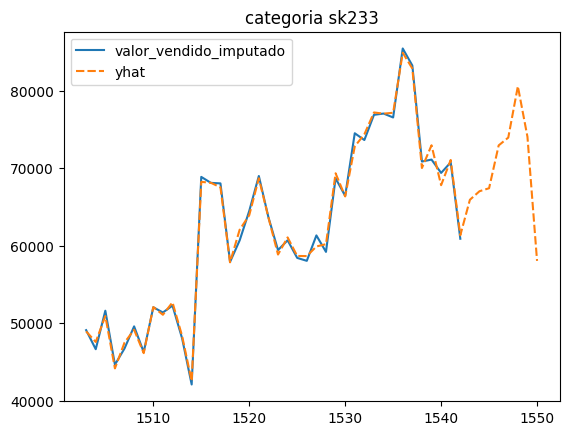

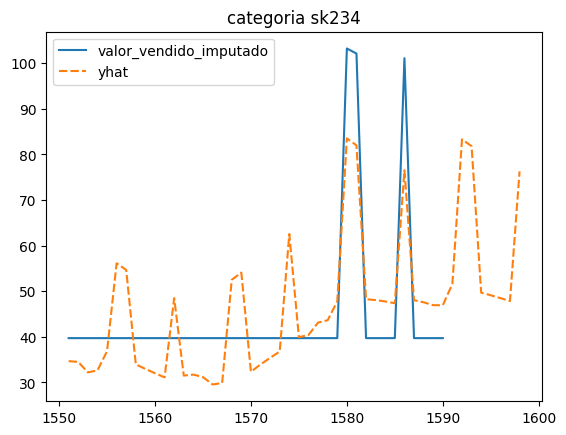

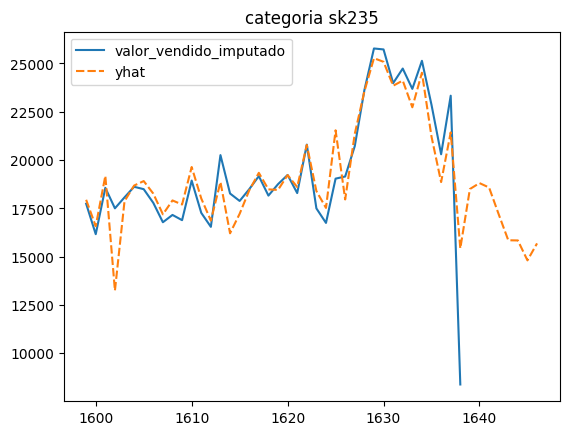

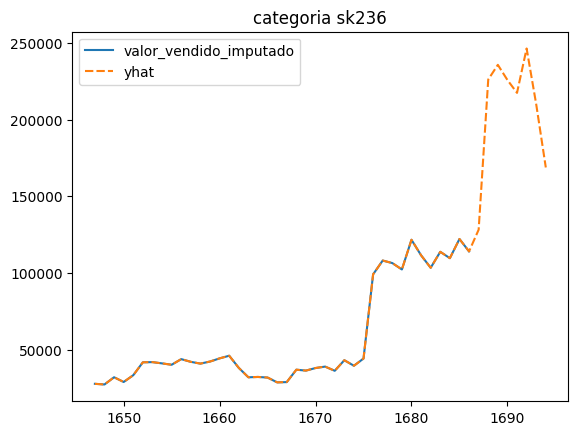

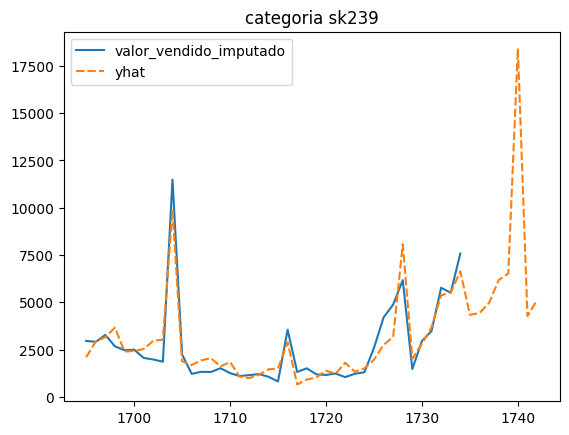

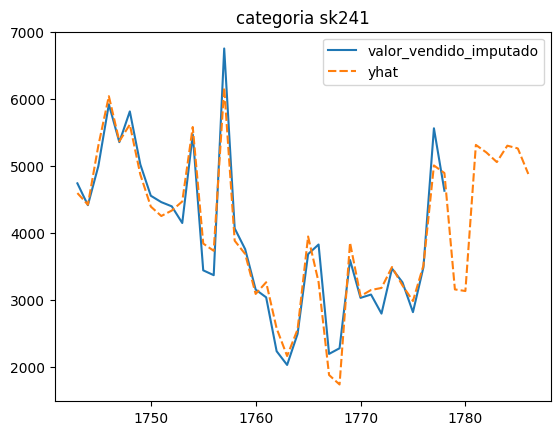

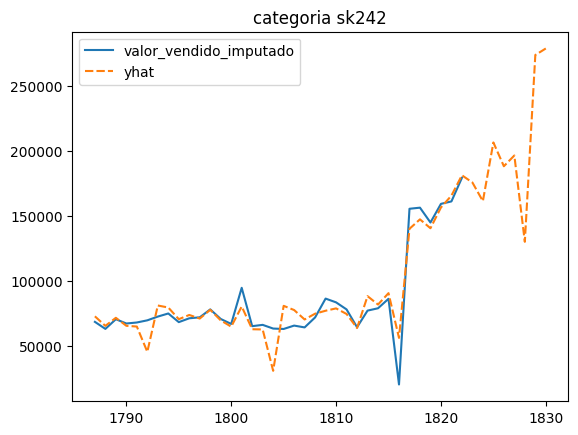

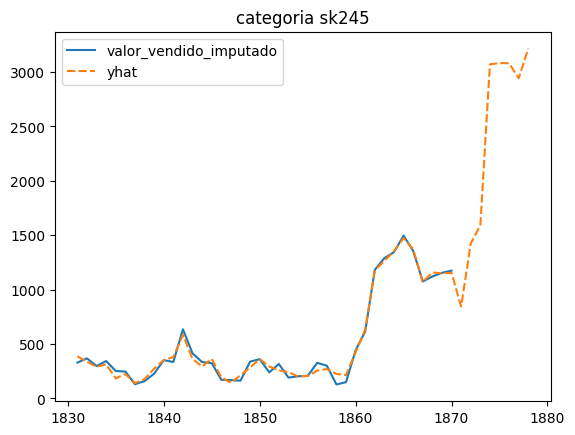

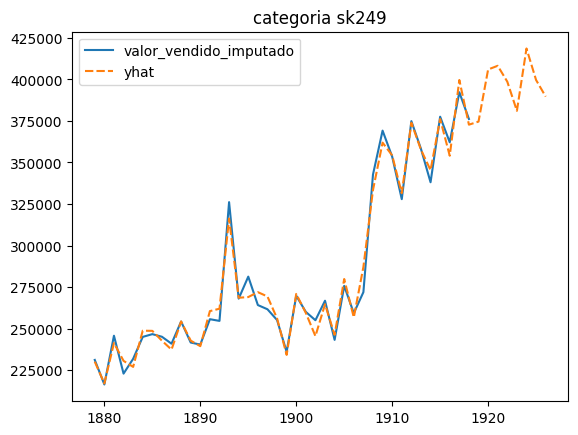

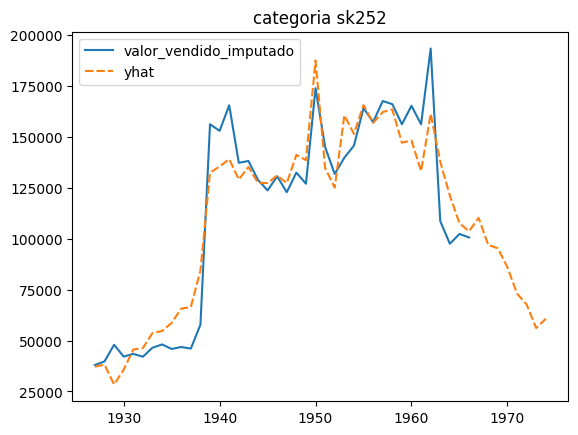

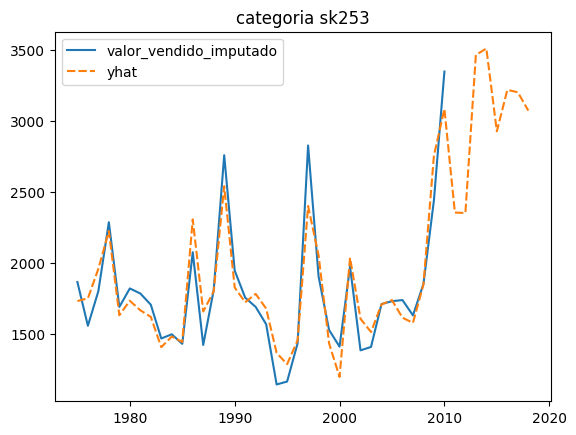

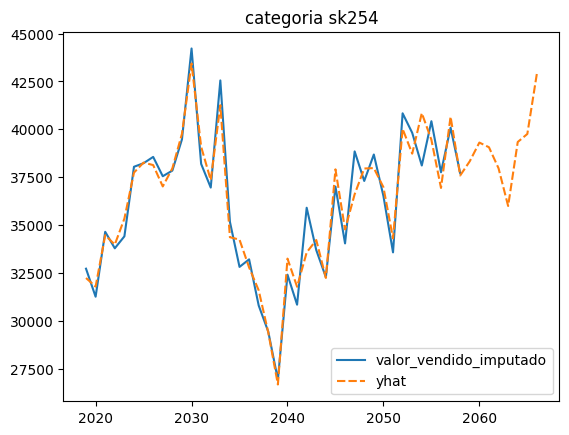

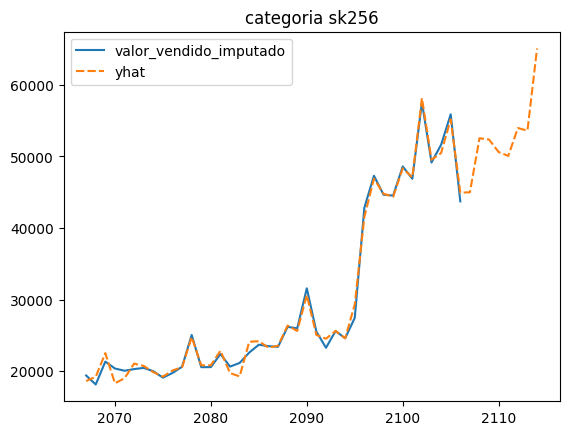

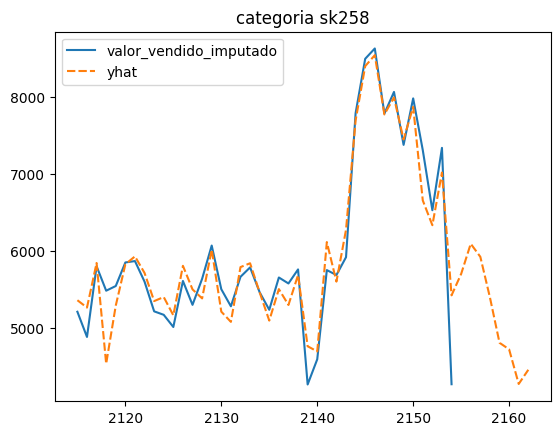

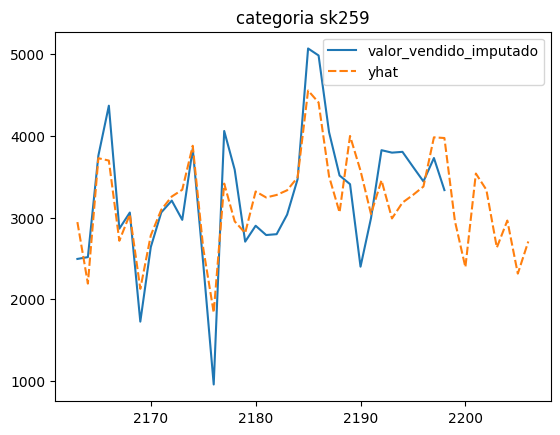

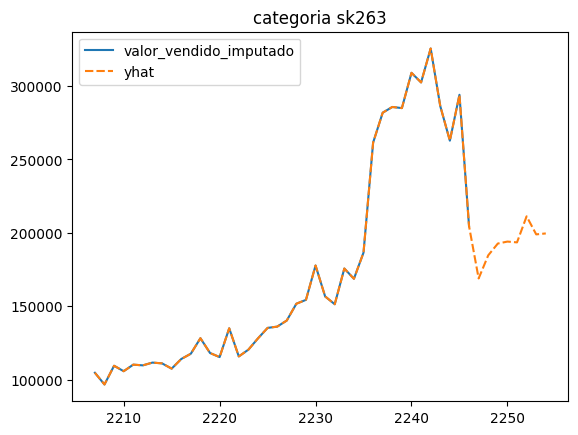

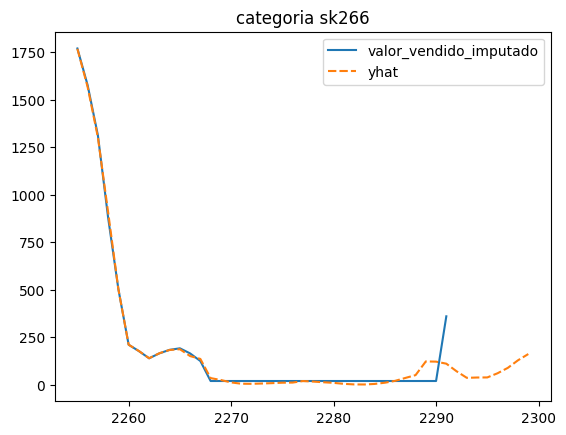

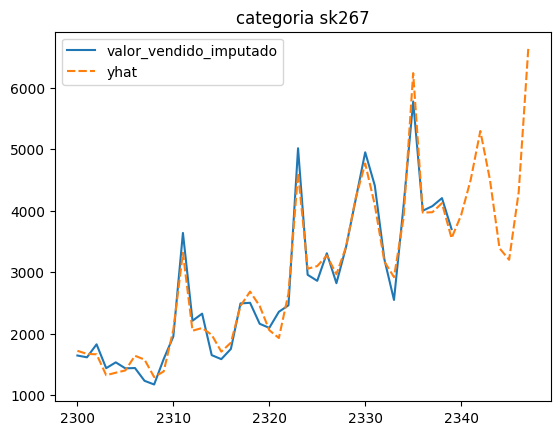

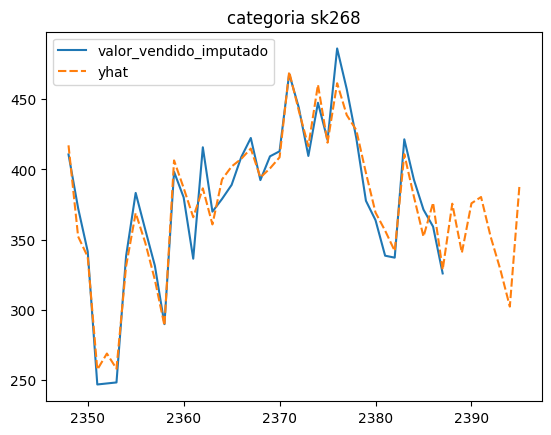

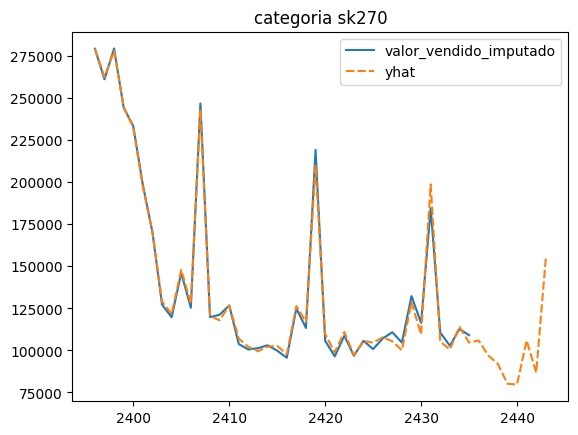

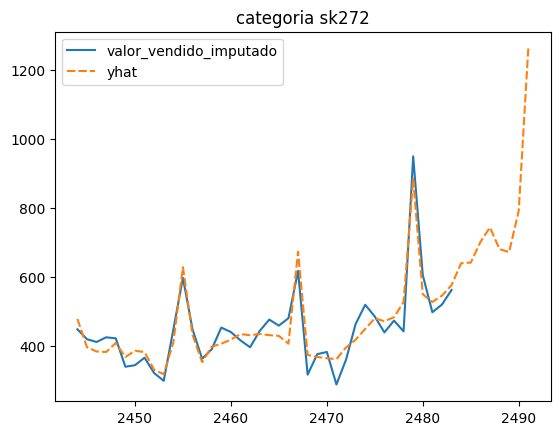

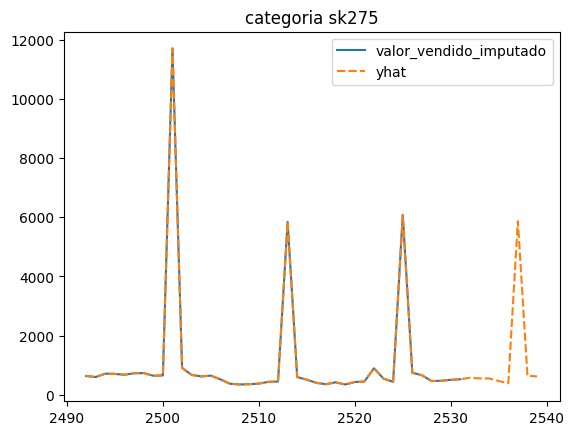

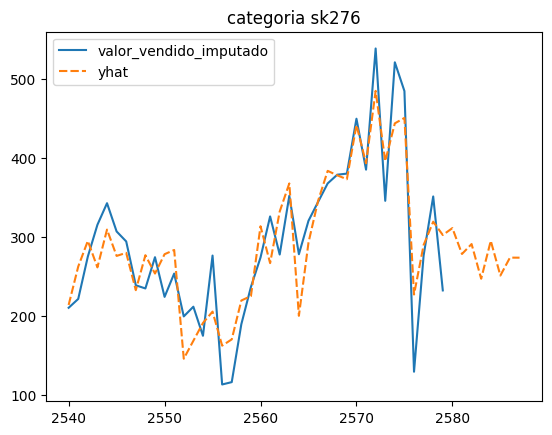

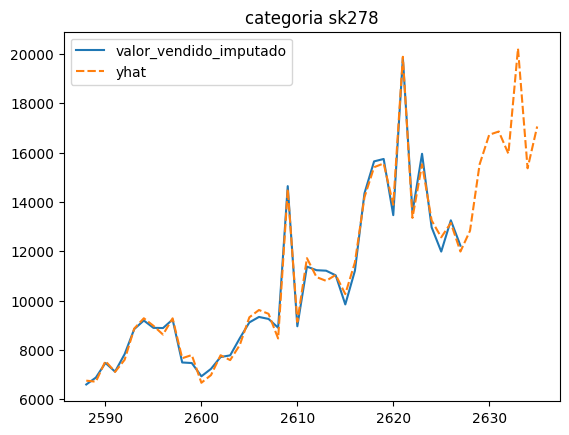

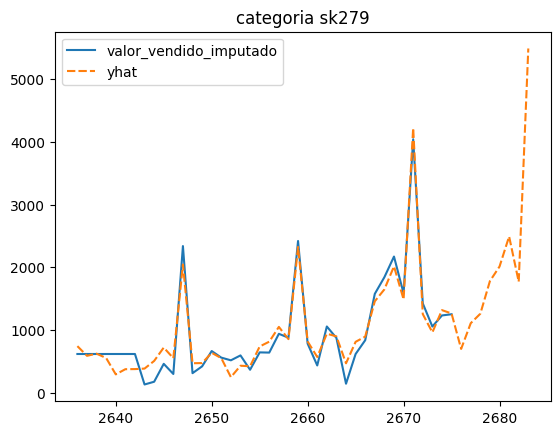

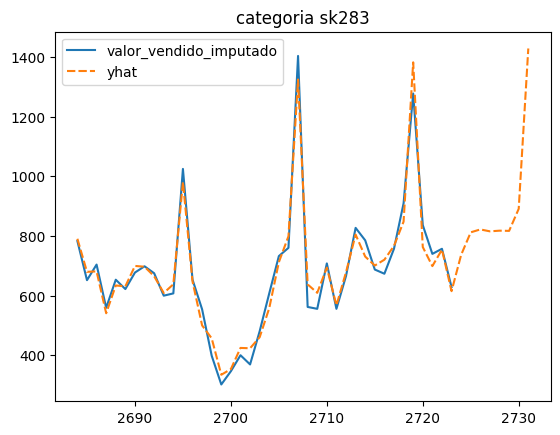

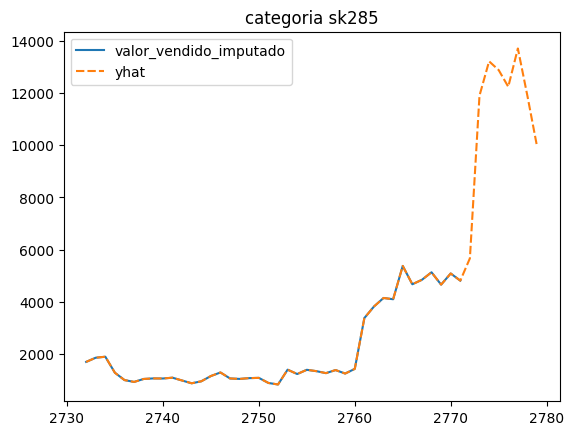

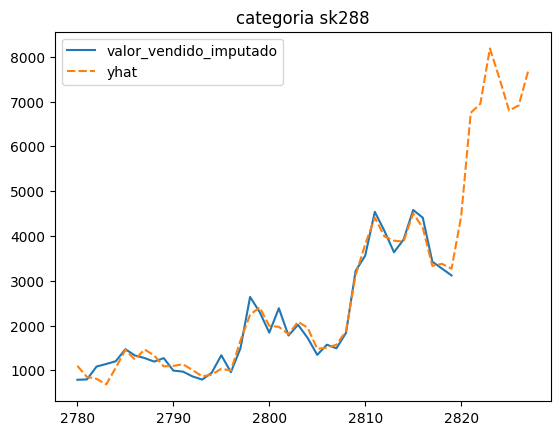

In [14]:
for i in cat:
    data = tablaf[tablaf['categoria_sk']==i]
    plot = data[['ds', 'valor_vendido_imputado','yhat']]
    sns.lineplot(data=plot)
    plt.title('categoria sk ' + str(i))
    plt.show()
    